In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from maze_env import MazeEnv
from maze import Maze

# Initialization of env.
maze = Maze(10, 10, 0, 0) 
env = MazeEnv(sz=10, maze=maze, start=np.array([0.05, 0.05]), goal=np.array([0.95, 0.95]),
               reward="distance", log=False, eval=False, dt=0.1, horizon=100, 
               wall_penalty=10, slide=1, image_freq=100)

# Function to generate valid points into the maze 
def generate_positions(env, num_samples=500, max_attempts=5000):
    positions = set()
    attempts = 0
    
    while len(positions) < num_samples and attempts < max_attempts:
        state = env.sample_open_state_continuous()
        
        # If the point lies on a wall, try again 
        if not env.point_collision(state[0], state[1]):
            positions.add(tuple(state))
        
        attempts += 1
    
    if len(positions) < num_samples:
        print(f"Warning: Only {len(positions)} unique positions generated out of {num_samples} requested.")
    
    return np.array(list(positions))

# Extended dead-end detection function
def is_dead_end_extended(env, x, y, radius=2):
    cx, cy = int(x * env.sz), int(y * env.sz)
    blocked_directions = 0
    
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            nx, ny = cx + dx, cy + dy
            if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
                blocked_directions += 1
            else:
                cell = env.maze.cell_at(nx, ny)
                if all(cell.walls.values()):
                    blocked_directions += 1
    
    return blocked_directions >= (radius * radius // 2)

def is_dead_end_bfs(env, x, y):
    from collections import deque

    # Coordinate di griglia
    cx, cy = int(x * env.sz), int(y * env.sz)

    # Se la cella di partenza è completamente chiusa, è triviale
    if all(env.maze.cell_at(cx, cy).walls.values()):
        return True

    nx, ny = env.maze.nx, env.maze.ny
    visited = set()
    queue = deque()
    queue.append((cx, cy))
    visited.add((cx, cy))

    while queue:
        cx, cy = queue.popleft()

        # Se siamo su un cella di bordo, NON è dead end
        # (oppure potresti controllare se ci sono muri aperti sul bordo, dipende dalla definizione).
        if cx == 0 or cy == 0 or cx == nx-1 or cy == ny-1:
            return False

        # Controllo celle adiacenti (N, S, E, W) in base ai muri
        cell = env.maze.cell_at(cx, cy)
        if not cell.walls["N"] and (cx, cy-1) not in visited:
            visited.add((cx, cy-1))
            queue.append((cx, cy-1))
        if not cell.walls["S"] and (cx, cy+1) not in visited:
            visited.add((cx, cy+1))
            queue.append((cx, cy+1))
        if not cell.walls["W"] and (cx-1, cy) not in visited:
            visited.add((cx-1, cy))
            queue.append((cx-1, cy))
        if not cell.walls["E"] and (cx+1, cy) not in visited:
            visited.add((cx+1, cy))
            queue.append((cx+1, cy))

    # Se esauriamo tutte le celle esplorabili senza mai raggiungere il bordo, è un dead-end
    return True


import numpy as np
from scipy.spatial import distance
from queue import PriorityQueue

def can_move(env, cx, cy, nx, ny):
    """
    Verifica se è possibile muoversi dalla cella (cx,cy) alla cella (nx,ny)
    controllando sia i limiti che i muri parziali.
    """
    # Se la cella di destinazione è fuori indice o completamente chiusa, non si può entrare
    if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
        return False
    if all(env.maze.cell_at(nx, ny).walls.values()):
        return False
    
    # Controlliamo i muri fra cella corrente e cella destinazione
    current_cell = env.maze.cell_at(cx, cy)
    next_cell    = env.maze.cell_at(nx, ny)
    dx = nx - cx
    dy = ny - cy

    # Muoversi a nord => dy=-1
    if dx == 0 and dy == -1:
        if current_cell.walls["N"] or next_cell.walls["S"]:
            return False
    # Muoversi a sud => dy=+1
    elif dx == 0 and dy == 1:
        if current_cell.walls["S"] or next_cell.walls["N"]:
            return False
    # Muoversi a est => dx=+1
    elif dx == 1 and dy == 0:
        if current_cell.walls["E"] or next_cell.walls["W"]:
            return False
    # Muoversi a ovest => dx=-1
    elif dx == -1 and dy == 0:
        if current_cell.walls["W"] or next_cell.walls["E"]:
            return False

    return True


def shortest_path_distance(env, x, y):
    """
    Esegue una ricerca di cammino minimo (tipo A*) dal punto (x,y) continuo 
    (in [0,1]^2) alla cella che contiene il goal env.goal,
    restituendo il costo (in celle attraversate) oppure np.inf se non esiste un percorso.
    """
    # Convertiamo le coordinate da [0..1] a celle
    cx, cy = int(x * env.sz), int(y * env.sz)
    goal_x, goal_y = int(env.goal[0] * env.sz), int(env.goal[1] * env.sz)
    
    frontier = PriorityQueue()
    frontier.put((0, (cx, cy)))         # coda prioritaria (costo stimato, (cx,cy))
    cost_so_far = {(cx, cy): 0}         # dizionario dei costi finora noti

    while not frontier.empty():
        _, current = frontier.get()     # estrai la cella con priorità minore
        if current == (goal_x, goal_y):
            # Abbiamo trovato il goal
            break

        current_cost = cost_so_far[current]
        
        # Proviamo tutte le direzioni (N, S, E, W)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = current[0] + dx, current[1] + dy
            
            # Verifica i muri
            if not can_move(env, current[0], current[1], nx, ny):
                continue
            
            new_cost = current_cost + 1
            # Se non abbiamo mai visitato next_pos o se abbiamo trovato un costo minore, aggiorna
            if (nx, ny) not in cost_so_far or new_cost < cost_so_far[(nx, ny)]:
                cost_so_far[(nx, ny)] = new_cost
                # euristica: distanza euclidea dalla destinazione
                priority = new_cost + distance.euclidean((nx, ny), (goal_x, goal_y))
                frontier.put((priority, (nx, ny)))
    
    # Se non è stato trovato un percorso, restituisce np.inf
    return cost_so_far.get((goal_x, goal_y), np.inf)


# Function to calculate the score points 
def compute_scores(env, positions):
    scores = []
    goal = np.array(env.goal)
    
    for pos in positions:
        x, y = pos
        
        # Distance from the goal 
        distance_to_goal = np.linalg.norm(goal - np.array([x, y]))
        
        # Distance from walls 
        epsilon = 0.03
        distances = [
            env.point_collision(x + epsilon, y),
            env.point_collision(x - epsilon, y),
            env.point_collision(x, y + epsilon),
            env.point_collision(x, y - epsilon)
        ]
        distance_from_wall = sum(1 for d in distances if not d) / len(distances)
        
        # Extended dead-end detection
        # is_dead_end = is_dead_end_extended(env, x, y)
        is_dead_end = is_dead_end_bfs(env, x, y)
        
        # Shortest path distance
        path_distance = shortest_path_distance(env, x, y) * (1.0 / env.sz)
        
        scores.append((x, y, distance_to_goal, distance_from_wall, is_dead_end, path_distance))
    
    return scores

# Generate the points 
points_to_generate = 2000
positions = generate_positions(env, num_samples=points_to_generate, max_attempts=10*points_to_generate)

# Calculate the scores per each point 
scores = compute_scores(env, positions)

# Save points and scores 
df_positions = pd.DataFrame(scores, columns=["x", "y", "distance_to_goal", "distance_from_wall", "is_dead_end", "path_distance"])
df_positions.to_parquet("positions.parquet", index=False)


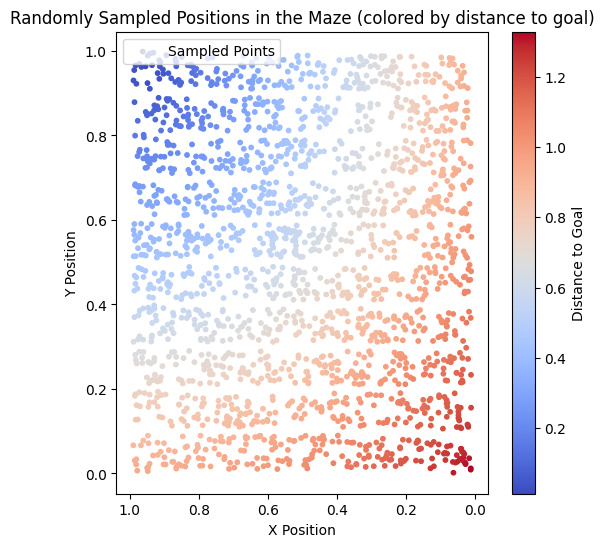

In [38]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_goal"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to goal)")
plt.colorbar(label="Distance to Goal")
plt.show()

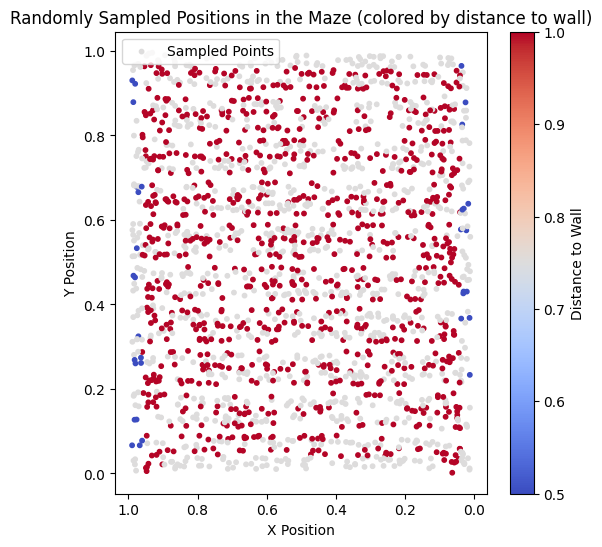

In [39]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_from_wall"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to wall)")
plt.colorbar(label="Distance to Wall")
plt.show()

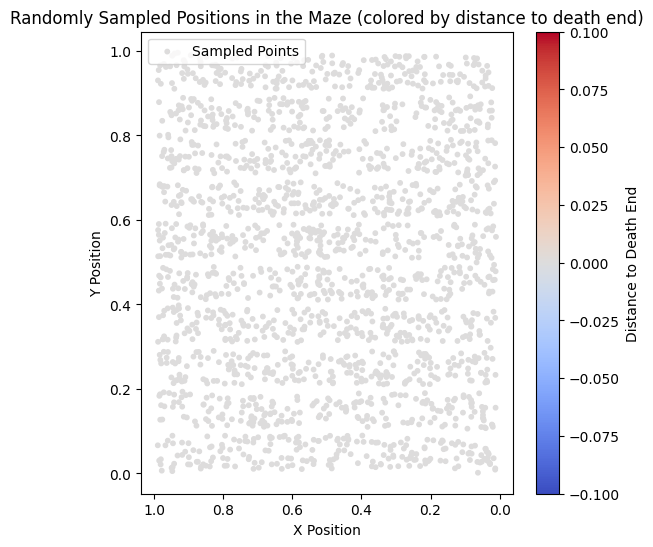

In [40]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["is_dead_end"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to death end)")
plt.colorbar(label="Distance to Death End")
plt.show()

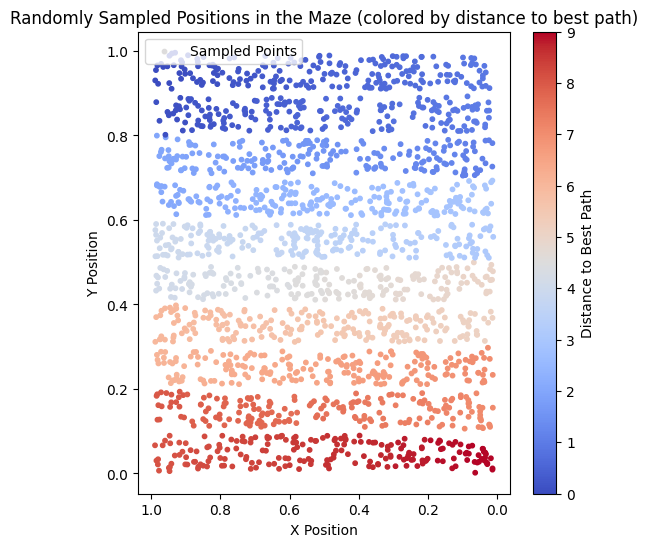

In [41]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["path_distance"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to best path)")
plt.colorbar(label="Distance to Best Path")
plt.show()